# Learning and controlling a room's temperature
### Farzad Vatandoust/email: vatandoustf@gamil.com

Load basic libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load The Data

In [149]:

df = pd.read_csv('data-B90102-30m.csv')

### Train/Test/Validation
Useful link https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

In [386]:
train_nu = int(np.floor(0.7 * len(df)))
test_nu = int(np.floor(0.15 * len(df)))
val_nu = len(df) - train_nu - test_nu

train_data = df[0:train_nu]
test_data = df[train_nu:train_nu + test_nu]
val_data = df[train_nu + test_nu: ]

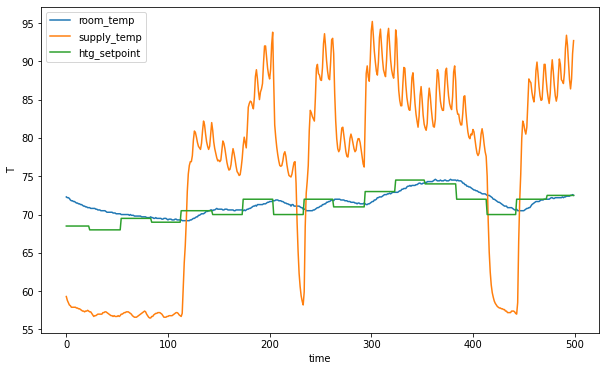

In [388]:
# plot the train data
firstn = 500
idx = np.arange(0, firstn, 1)
fig = plt.figure(figsize=(10, 6))
plt.plot(idx, train_data['room_temp'][0:firstn])
plt.plot(idx, train_data['supply_temp'][0:firstn])
plt.plot(idx, train_data['htg_setpoint'][0:firstn])
plt.legend(["room_temp", "supply_temp", "htg_setpoint"])
plt.xlabel('time')
plt.ylabel('T')
plt.show()

# Section 1: Learn a differential equation model

Load required libraries

In [389]:
from scipy.integrate import odeint, solve_ivp
from scipy import optimize

## Model Defenition
- p[1, 2, 3, 4] = K, Ta, ca, dt, C
- u[1] = T
- we have some function Ts and MS
- Useful link http://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations

Solver odeint


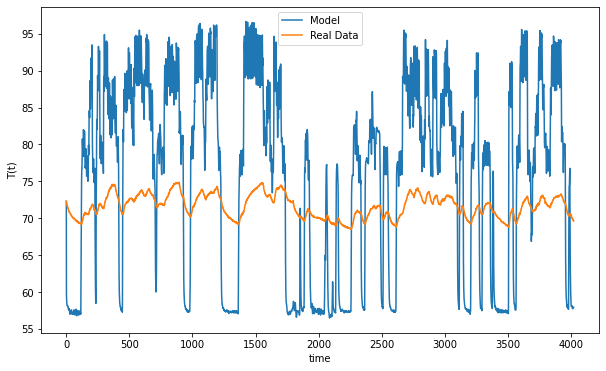

In [390]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt

p = np.array([100, 68.94, 11, 100, 1000])
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = [t[i-1], t[i]]
    # solve ODE
    z = odeint(model, z0, ts, args=(p, Ts[i-1], Ms[i-1]), tfirst=True)
    T[i] = z[-1]
    z0 = z[-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

Solve_ivp (faster)

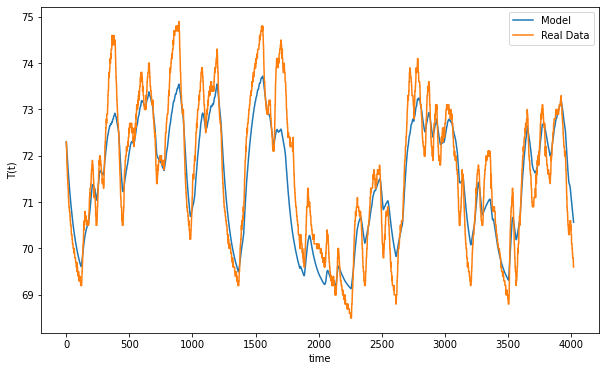

In [426]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = np.array([26.65, 68.94, 0.007, 35.96, 2007.35])
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

Loss

In [428]:
def objective_func(p):
    # Temporary !!!!!!!!!!!!!!!
    train_nu = 100
    #!!!!!!!!!!!!!!!!!!!!!!!!!!
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]), method = 'RK23')
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    real = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    mse = sum((real-predicted)**2)/train_nu
    return mse
    

In [429]:
p = np.array([10, 10, 10, 10, 10])
objective_func(p)

174.97306163213267

## Global optimizer



In [436]:
bounds = [(0.0, 200), 
            (0.0, 200),
            (0.0, 200),
            (0, 200),
            (1000, 10000)]
Nfeval = 1
def callbackF(Xi, k1, k2):
    global Nfeval
    print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}  {5: 3.6f}  {6: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3], Xi[4], objective_func(Xi)))
    Nfeval += 1
print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}  {5:9s}   {6:9s}'.format('Iter', ' X1', ' X2', ' X3', ' X4', ' X5', 'f(X)'))
result = optimize.dual_annealing(objective_func, bounds, callback=callbackF)

Iter    X1          X2          X3          X4         X5         f(X)     
   1    138.618622    173.493716    69.401697    161.444070   1591.737602   157.612269
   2    140.035918    174.911013    70.818994    97.866955   2392.700818   157.594112
   3    56.906795    68.710827    0.013209    96.804577   2397.221132   0.004418


In [439]:
objective_func(result.x)


0.0044177788087718705

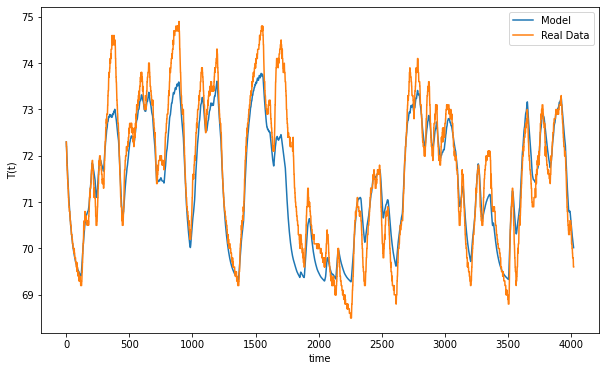

In [440]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = result.x
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

# Section 2: Learn  a Neural Network Model

Lets import the required packages

Now we Create our network